In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import * 
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH="/home/ubuntu/cjt_fastai/fastai/courses/dl1/data/dogscats/"
sz=224  # images will be resized to this (to speed training?)
print(torch.cuda.is_available())  # check that GPU is setup correctly 
print(torch.backends.cudnn.enabled) # check for accelerated fncs

True
True


/home/ubuntu/cjt_fastai/fastai/courses/dl1/data/dogscats/
['tmp', 'test1', 'valid', 'models', 'train', 'sample']
['cats', 'dogs']
files: ['cat.1935.jpg', 'cat.12009.jpg', 'cat.6320.jpg', 'cat.2203.jpg', 'cat.3808.jpg']
(499, 412, 3)


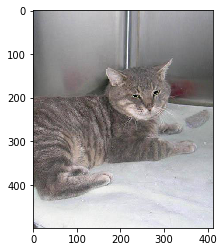

In [2]:
# basic dataset exploration 
print(PATH)
print(os.listdir(PATH))
print(os.listdir(f'{PATH}valid'))
print(f"files: {os.listdir(f'{PATH}valid/cats')[:5]}")
files = os.listdir(f'{PATH}valid/cats')[:5]
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)
print(img.shape)
# print(img[:4,:4])

In [5]:
# Start with pretrained resnet module 
# more info: https://github.com/KaimingHe/deep-residual-networks
#... pretrained on ImageNet (1.2 million images with 1000 classes) 
#... resnet34 won the 2015 ImageNet competition
arch=resnet34
batch_size=32
data = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [7]:
lrf=learn.lr_find()

A Jupyter Widget

 71%|███████   | 510/719 [00:04<00:01, 114.23it/s, loss=0.211] 


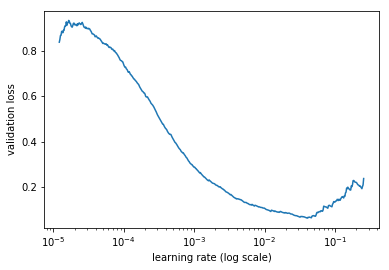

In [8]:
learn.sched.plot()

In [9]:
# now have learning rate. try fitting. Note that how after about two epochs, the mode starts overfitting. 
# you can diagnose overfitting by watching the training loss decrease while the validation loss plateaus 
# this means the NN is essentially memorizing the training images
learn.fit(0.01, 5)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.059381   0.028415   0.991     
    1      0.045168   0.024893   0.99                          
    2      0.039264   0.026411   0.993                         
    3      0.033841   0.026321   0.9915                        
    4      0.031376   0.025981   0.9905                        



[array([ 0.02598]), 0.99050000000000005]

In [10]:
# make some helper functions 
def rand_by_mask(mask):
    # get 4 random images from class
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    # get correct images 
    return rand_by_mask((preds==data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0]] for x in idxs)
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(imgs, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for ii in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, ii+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[ii], fontsize=16)
        plt.imshow(imgs[ii])
        
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds==data.val_y)==is_correct) \
            & (data.val_y==y), mult)

def get_augs(tfms):
    """Show augmentation images"""
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

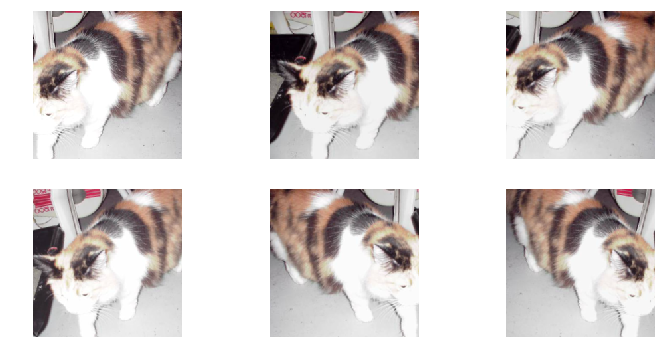

In [11]:
# Now try with data augmentation (on new network)
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

#... show some examples
ims = np.stack([get_augs(tfms) for i in range(6)])
plots(ims, rows=2)


In [13]:
data = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.precompute=False  # still unsure what this does exactly, but I'm pretty sure we need to do this when using transformations
learn.fit(1e-2, 5)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.066589   0.028567   0.99      
    1      0.042726   0.027592   0.9905                       
    2      0.061004   0.023115   0.9915                       
    3      0.051556   0.026181   0.991                        
    4      0.050616   0.02536    0.992                        



[array([ 0.02536]), 0.99199999999999999]

In [14]:
# now try with SGDR (stochastic gradient descent with restarts)
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.045983   0.025396   0.99      
    1      0.034789   0.025867   0.992                        
    2      0.037937   0.025371   0.991                        



[array([ 0.02537]), 0.99099999999999999]

A Jupyter Widget

 58%|█████▊    | 420/719 [03:54<02:46,  1.79it/s, loss=0.237] 

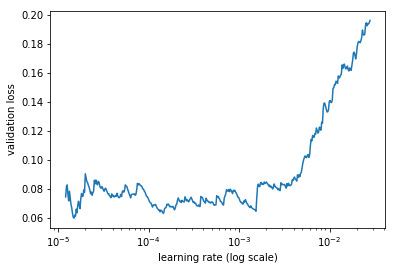

In [17]:
learn.lr_find()
# learn.sched.plot_lr()
learn.sched.plot()

In [18]:
# fine tuning and differential learning rate annealing
learn.unfreeze()  # unfreeze to fine-tune prior layers
lr=np.array([1e-4,1e-3,1e-2])  # set learning rates for groups of layers
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)  # train again with SGDR

A Jupyter Widget

  2%|▏         | 15/719 [00:09<07:12,  1.63it/s, loss=0.104] 


Exception in thread Thread-42:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      0.044015   0.02772    0.9885    
    1      0.032771   0.024032   0.991                        
    2      0.030638   0.027704   0.9885                       
    3      0.035807   0.02792    0.989                        
    4      0.027863   0.02277    0.9915                       
    5      0.018281   0.023989   0.9915                       
    6      0.025001   0.024513   0.991                        



[array([ 0.02451]), 0.99099999999999999]

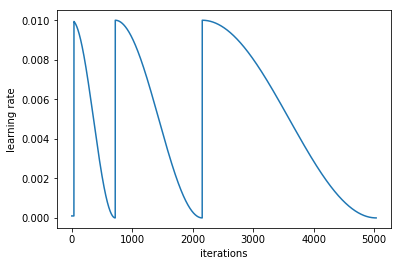

In [19]:
learn.sched.plot_lr()  # plot learning rate of final layers

In [22]:

# now lets look at the errors
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)


0.99250000000000005

[[997   3]
 [ 12 988]]


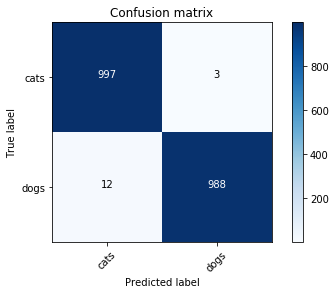

In [23]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


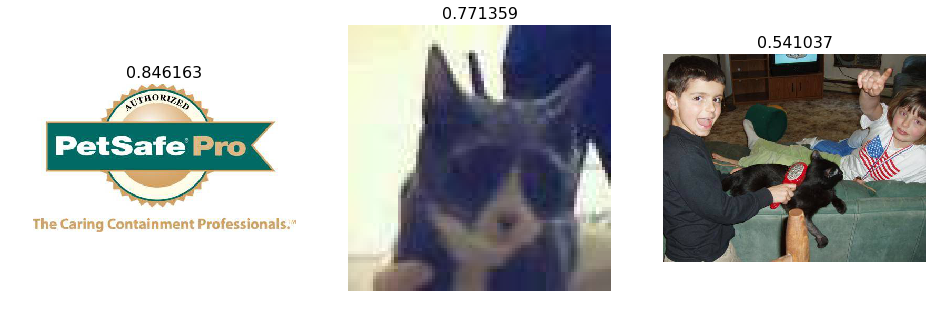

In [24]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


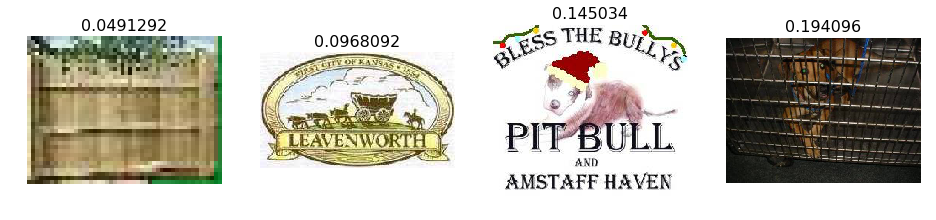

In [25]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [ ]:
# Easy steps to train world class classifier:
# https://youtu.be/JNxcznsrRb8?t=1h13m21s

#     precompute=True
#     Use lr_find() to find highest learning rate where loss is still clearly improving
#     Train last layer from precomputed activations for 1-2 epochs
#     Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
#     Unfreeze all layers
#     Set earlier layers to 3x-10x lower learning rate than next higher layer. (lower if closer to original training set)
#     Use lr_find() again
#     Train full network with cycle_mult=2 until over-fitting

